In [21]:
# here we are examining the difference between the convolution approximation and actualy counting for the number of people in the home state

import numpy as np
import igraph as ig
import network_conversion as ntc
from collections import Counter
from matplotlib import pyplot as plt, colors
import seaborn as sns

In [2]:
ordering = ntc.Ordering.from_file("./concordant_networks/size_14.csv")

In [3]:
snaps = ntc.SnapshotWithHomeConverter.load_snapshots("./conc_tempo_14_detailed/")

In [4]:
snaps[0].es[0]

igraph.Edge(<igraph.Graph object at 0x7df53505a340>, 0, {'source': 3805.0, 'target': 2758.0, 'weight': 2.0, 'departures': 1.0, 'arrivals': 0.0})

In [5]:
s0 = snaps[0]

In [6]:
Counter(s0.count_multiple())

Counter({1: 4299})

In [7]:
len(ordering.order)

338

In [8]:
def get_adjs(graf, key, ordering):
    raw_order = graf.vs['name']
    paste_order = [ordering[int(k)] for k in raw_order]

    sz = len(ordering.order)
    A = np.zeros((sz, sz))
    A[np.ix_(paste_order, paste_order)] = np.array(graf.get_adjacency(attribute=key).data)
    return A

In [9]:
get_adjs(s0, 'departures', ordering)

array([[  5.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   7.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  13., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  17.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   5.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 104.]])

In [10]:
DS = []
AS = []
for k in sorted(snaps.keys()):
    sg = snaps[k]
    DS.append(get_adjs(sg, 'departures', ordering))
    AS.append(get_adjs(sg, 'arrivals', ordering))

In [11]:
N = len(ordering.order)
HS = []
H = np.zeros((N,N))
for d,a in zip(DS, AS):
    H += d
    HS.append(np.array(H)) 
    H -= a

/home/davidwu/.virtualenvs/monv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

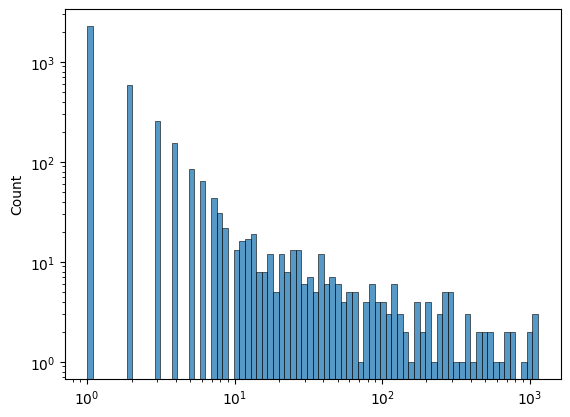

In [12]:
sns.histplot(HS[0][HS[0] > 0], log_scale=(True, True))

<Axes: >

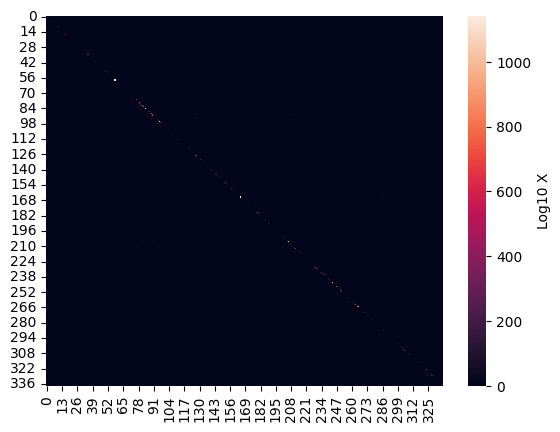

In [13]:
sns.matrix.heatmap((HS[0]), cbar_kws={'label': 'Log10 X'}, robust=False)

In [14]:
def powkerest(xs, powx=-0.6, trunc=26):
    W = []
    for i,x in enumerate(xs):
        if i == 0:
            W.append(x)
            continue
        pk = ntc.SnapshotWithHomeConverter.power_kernel(i, power=powx, trunc=trunc)
        i0 = np.clip(i - trunc, 0, i)
        W.append(np.sum(xs[i0:i] * pk[:, np.newaxis, np.newaxis], axis=0))
    return W

In [15]:
XE = powkerest(DS)

In [57]:
IX = 150
Y = (HS[IX] - XE[IX]) / (HS[IX] + 1)

Text(0.5, 1.0, 'Relative error between exact number of patients at home \nvs. approximation by power-law kernel convolution')

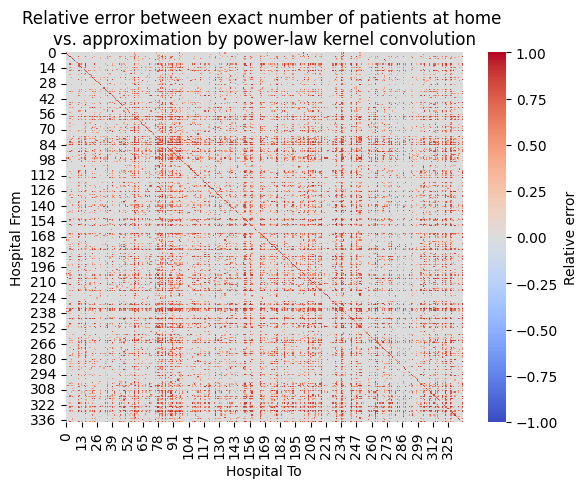

In [59]:
sns.matrix.heatmap(Y, cbar_kws={'label': 'Relative error'}, cmap='coolwarm', norm=colors.CenteredNorm(halfrange=1.0))
plt.xlabel('Hospital To')
plt.ylabel('Hospital From')
plt.title('Relative error between exact number of patients at home \nvs. approximation by power-law kernel convolution')
# plt.savefig('kernel_convolve_error.png', dpi=200)

/home/davidwu/.virtualenvs/monv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/davidwu/.virtualenvs/monv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Relative error between exact number of patients at home \nvs. approximation by power-law kernel convolution')

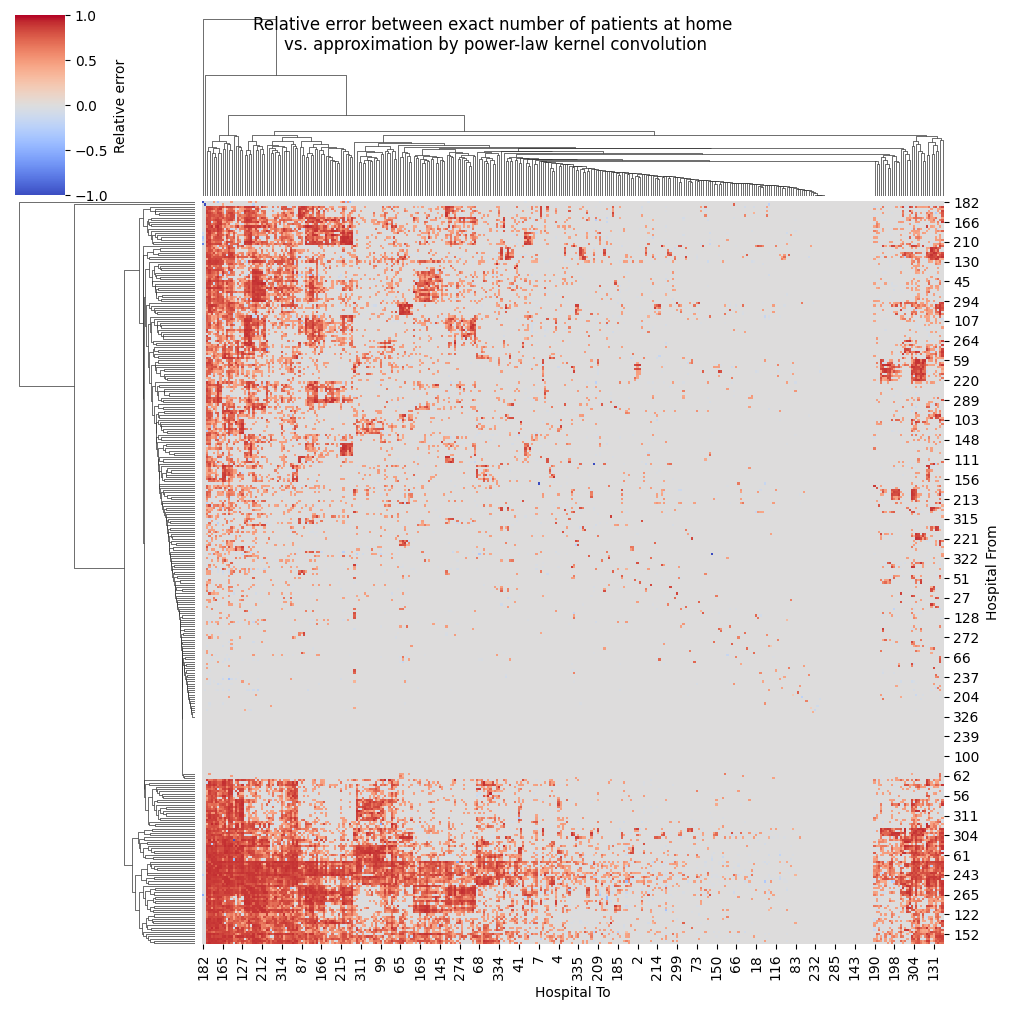

In [58]:
cg = sns.matrix.clustermap(Y, cbar_kws={'label': 'Relative error'}, cmap='coolwarm', norm=colors.CenteredNorm(halfrange=1.0))
cg.ax_heatmap.set_xlabel('Hospital To')
cg.ax_heatmap.set_ylabel('Hospital From')
cg.fig.suptitle('Relative error between exact number of patients at home \nvs. approximation by power-law kernel convolution')

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.14239e+05]),
 array([-18.45222658, -16.51309421, -14.57396185, -12.63482949,
        -10.69569713,  -8.75656477,  -6.81743241,  -4.87830004,
         -2.93916768,  -1.00003532,   0.93909704]),
 <BarContainer object of 10 artists>)

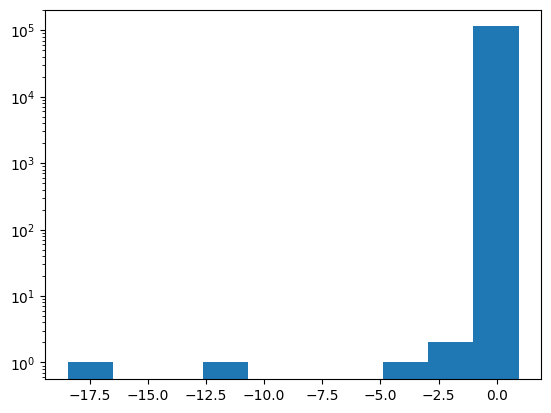

In [68]:
plt.hist(Y.flatten(), log=True)